## TODO:

- develop training and (validate and/or test) sets that are distinct
  - test set must be labeled for us to evalute model. 
    - training and validate can be unlabled. we can evaluate based on clusters.

- run entire (training) set in colab eventually...?
  - 80 20 split

- utilize `make_dot` to print model as a graph


## Fetch and Download data

In [1]:
!gdown 15C5spf1la7L09kvWXll2qt67Ec0rwLsY                                          # Download data
!tar -zxf aia_171_color_1perMonth.tar.gz && rm aia_171_color_1perMonth.tar.gz     # Unzip data

Downloading...
From: https://drive.google.com/uc?id=15C5spf1la7L09kvWXll2qt67Ec0rwLsY
To: /content/aia_171_color_1perMonth.tar.gz
100% 146M/146M [00:00<00:00, 213MB/s]


## Clones repo & Install all libraries and requirements

In [ ]:
!git clone https://github.com/hits-sdo/hits-sdo-similaritysearch                  # Clone repo

In [ ]:
# Move repo's directory as workspace
%cd hits-sdo-similaritysearch/

In [ ]:
# switch to correct branch
!git checkout ss_dataloader

In [ ]:
!pip install -r requirements.txt                                                  # Install all libraries
!pip install wandb

## Restart Runtime (see above), change directory


In [1]:
%cd hits-sdo-similaritysearch

/content/hits-sdo-similaritysearch


## Import packages / modules

In [2]:
import math

import numpy as np
import torch
import torch.nn as nn
import torchvision

import matplotlib.pyplot as plt

from lightly.data import ImageCollateFunction, LightlyDataset, collate
from lightly.loss import NegativeCosineSimilarity
from lightly.models.modules.heads import ( 
    SimSiamPredictionHead, 
    SimSiamProjectionHead
)

import os
import matplotlib.offsetbox as osb                                            

import torchvision.transforms.functional as functional
from matplotlib import rcParams as rcp
from PIL import Image

from sklearn import random_projection

from sdo_augmentation.augmentation_list import AugmentationList
from sdo_augmentation.augmentation import Augmentations



from search_utils.image_utils import read_image, stitch_adj_imgs
from search_simsiam.custom_collate import sunbirdCollate

import glob

## Setting up path to raw data

In [3]:
path_to_data = '/content/aia_171_color_1perMonth'                                 # Path to raw data

## Setting up Hyper-parameters

In [9]:
num_workers = 8                                                                   # How many process giving model to train -- similar to threading
batch_size = 256                                                                  # A subset of files that the model sees to update it's parameters
seed = 1                                                                          # Seed for random generator for reproducability
epochs = 20                                                                       # How many times we go through our entire data set
input_size = 128                                                                  # The number of pixels in x or y

num_ftrs = 512 

stride = 10                                                                   # Dimension of the embeddings


# Dimension of the output of the prediction and projection heads
out_dim = proj_hidden_dim = 512

# The prediction head uses a bottleneck architecture
pred_hidden_dim = 128

## Fix seed for reproducibility

In [6]:
# seed torch and numpy 
# used for reproducibility in creating the model
torch.manual_seed(0)
np.random.seed(0)

## Defining dataset and data loader

*   Setting up data set 
*   Build the collate function 
*   List item







In [7]:
# create a lightly dataset for training, since the augmentations are handled
# by the collate function, there is no need to apply additional ones here
dataset_train_simsiam = LightlyDataset(input_dir=path_to_data)

if stride>1:
  indices = range(0, len(dataset_train_simsiam), stride)
  dataset_train_simsiam = torch.utils.data.Subset(dataset_train_simsiam, indices)



#3283 x 32 = 10506
print(len(dataset_train_simsiam))
# returns image, folder num, tile name
#print(dataset_train_simsiam)
# for data in dataset_train_simsiam:
#   print(data)

10506


Build collate function 

In [10]:
#achieve similar function as the top using the fil_type
#an example wold be a nested function 
#implement through a class or a nested function 

fill_type = "SuperImage"
sun_bird_collate_fn = sunbirdCollate(path_to_data=path_to_data, fill_type=fill_type)

collate_fn = ImageCollateFunction(
    input_size=input_size,
    # require invariance to flips and rotations
    hf_prob=0.5,
    vf_prob=0.5,
    rr_prob=0.5,
    # satellite images are all taken from the same height
    # so we use only slight random cropping
    min_scale=0.5,
    # use a weak color jitter for invariance w.r.t small color changes
    cj_prob=0.2,
    cj_bright=0.1,
    cj_contrast=0.1,
    cj_hue=0.1,
    cj_sat=0.1,
)

(<PIL.Image.Image image mode=RGB size=128x128 at 0x7FAE1DD278B0>, 0, '20100601_000036_aia.lev1_euv_12s_4k/tiles/20100601_000036_aia.lev1_euv_12s_4k_tile_1024_2304.jpg')
tensor([0]) ['20100601_000036_aia.lev1_euv_12s_4k_tile_3072_3584.jpg', '20100601_000036_aia.lev1_euv_12s_4k_tile_1152_3072.jpg', '20100601_000036_aia.lev1_euv_12s_4k_tile_1024_2432.jpg', '20100601_000036_aia.lev1_euv_12s_4k_tile_256_2688.jpg', '20100601_000036_aia.lev1_euv_12s_4k_tile_2048_1024.jpg', '20100601_000036_aia.lev1_euv_12s_4k_tile_768_3456.jpg', '20100601_000036_aia.lev1_euv_12s_4k_tile_1792_2304.jpg', '20100601_000036_aia.lev1_euv_12s_4k_tile_2816_1920.jpg', '20100601_000036_aia.lev1_euv_12s_4k_tile_1536_2176.jpg', '20100601_000036_aia.lev1_euv_12s_4k_tile_2048_2816.jpg', '20100601_000036_aia.lev1_euv_12s_4k_tile_2816_2048.jpg', '20100601_000036_aia.lev1_euv_12s_4k_tile_2944_2176.jpg', '20100601_000036_aia.lev1_euv_12s_4k_tile_3072_640.jpg', '20100601_000036_aia.lev1_euv_12s_4k_tile_640_1536.jpg', '20100601_

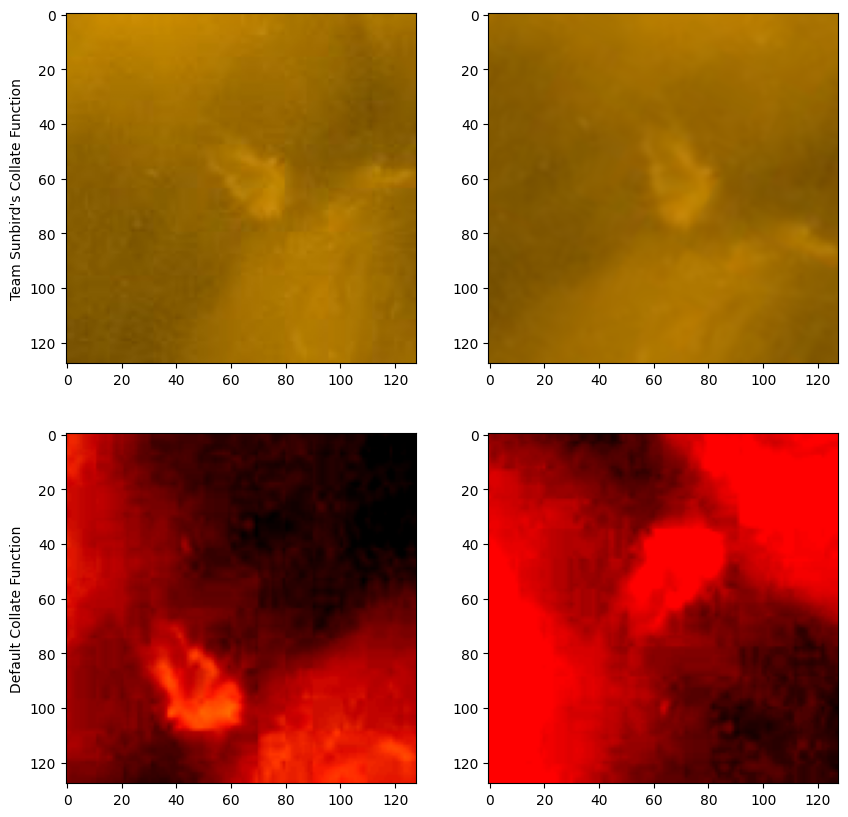

In [12]:
dataset_train_simsiam.dataset[0]
print(dataset_train_simsiam.dataset[10])
(img_t0,img_t1),label,file_name = sun_bird_collate_fn([dataset_train_simsiam.dataset[10]])

plt.figure(figsize = (10,10))

print(label,file_name)
plt.subplot(2,2,1)
plt.imshow(img_t0.permute(2,3,1,0)[:,:,:,0])
plt.ylabel("Team Sunbird's Collate Function")
plt.subplot(2,2,2)
plt.imshow(img_t1.permute(2,3,1,0)[:,:,:,0])


dataset_train_simsiam.dataset[0]
(img_t0,img_t1),label,file_name = collate_fn([dataset_train_simsiam.dataset[10]])

print(label,file_name)
plt.subplot(2,2,3)
plt.imshow(img_t0.permute(2,3,1,0)[:,:,:,0])
plt.ylabel("Default Collate Function")
plt.subplot(2,2,4)
plt.imshow(img_t1.permute(2,3,1,0)[:,:,:,0])

In [13]:
# create a dataloader for training
dataloader_train_simsiam = torch.utils.data.DataLoader(
    dataset_train_simsiam,
    batch_size=batch_size,
    shuffle=True,           # data reshuffled at every epoch if True
    collate_fn=sun_bird_collate_fn,  # constructs function
    drop_last=True,         # If want to merge datasets (optional) - mostly used when batches are loaded from map-styled datasets.
    num_workers=num_workers,
)

# create a torchvision transformation for embedding the dataset after training
# here, we resize the images to match the input size during training and apply
# a normalization of the color channel based on statistics from imagenet
test_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((input_size, input_size)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=collate.imagenet_normalize["mean"],
            std=collate.imagenet_normalize["std"],
        ),
    ]
)

# create a lightly dataset for embedding
dataset_test = LightlyDataset(input_dir=path_to_data, transform=test_transforms)

# create a dataloader for embedding
dataloader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers,
)
     

# **Build and Train the Model**

In [14]:
class SimSiam(nn.Module):
    def __init__(self, backbone, num_ftrs, proj_hidden_dim, pred_hidden_dim, out_dim):
        super().__init__()
        self.backbone = backbone
        self.projection_head = SimSiamProjectionHead(num_ftrs, proj_hidden_dim, out_dim)
        self.prediction_head = SimSiamPredictionHead(out_dim, pred_hidden_dim, out_dim)

    def forward(self, x):
        # get representations
        f = self.backbone(x).flatten(start_dim=1)
        # get projections
        z = self.projection_head(f)
        # get predictions
        p = self.prediction_head(z)
        # stop gradient
        z = z.detach()
        return z, p


# we use a pretrained resnet for this tutorial to speed
# up training time but you can also train one from scratch
resnet = torchvision.models.resnet18()
backbone = nn.Sequential(*list(resnet.children())[:-1])
model = SimSiam(backbone, num_ftrs, proj_hidden_dim, pred_hidden_dim, out_dim)

### **Display Model**

In [ ]:
model

In [25]:
# SimSiam uses a symmetric negative cosine similarity loss
criterion = NegativeCosineSimilarity()

# scale the learning rate
lr = 0.05 * batch_size / 256
# use SGD with momentum and weight decay
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)

In [26]:
import wandb
import random # for demo script

wandb.login()

<IPython.core.display.Javascript object>

KeyboardInterrupt: ignored

In [ ]:
run = wandb.init(
    entity="search-byol",
    # Set the project where this run will be logged
    project="search-simsiam",
    # Track hyperparameters and run metadata
    config={
        "learning_rate": lr,
        "epochs": epochs,
        "batch_size": batch_size,
        "collate_fn": "sunbird_collate",
        "fill_type": fill_type,
        "data_stride": stride
    })


In [ ]:
#true if currently have GPU
torch.cuda.is_available()

#check pgu count
#not number of workers, that is seperate
torch.cuda.device_count()

1

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

device = "mps" if torch.backends.mps.is_available() else device

model.to(device)

loss_list = []
collapse_list = []

avg_loss = 0.0
avg_output_std = 0.0
for e in range(epochs):
    batch_count = 0

    # for each batch in dataloader
    # x0: first augmentation batch
    # x1: second augmentation batch
    for (x0, x1), _, _ in dataloader_train_simsiam:
        # move images to the gpu
        x0 = x0.float().to(device)
        x1 = x1.float().to(device)

        # print shape of batches
        print(f'Batch shapes: {x0.shape}, {x1.shape}')

        # run the model on both transforms of the images
        # we get projections (z0 and z1) and
        # predictions (p0 and p1) as output
        z0, p0 = model(x0)
        z1, p1 = model(x1)

        # apply the symmetric negative cosine similarity
        # and run backpropagation
        loss = 0.5 * (criterion(z0, p1) + criterion(z1, p0))
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        # calculate the per-dimension standard deviation of the outputs
        # we can use this later to check whether the embeddings are collapsing
        output = p0.detach()
        output = torch.nn.functional.normalize(output, dim=1)

        output_std = torch.std(output, 0)
        output_std = output_std.mean()
        batch_count += 1
        print(batch_count)
        print(loss)
        # if(batch_count == 10):
        #   break
        # use moving averages to track the loss and standard deviation
        w = 0.9
        avg_loss = w * avg_loss + (1 - w) * loss.item()
        avg_output_std = w * avg_output_std + (1 - w) * output_std.item()

    # the level of collapse is large if the standard deviation of the l2
    # normalized output is much smaller than 1 / sqrt(dim)
    collapse_level = max(0.0, 1 - math.sqrt(out_dim) * avg_output_std)
    # print intermediate results
    print(
        f"[Epoch {e:3d}] "
        f"Loss = {avg_loss:.2f} | "
        f"Collapse Level: {collapse_level:.2f} / 1.00"
    )

    loss_list.append(avg_loss)
    collapse_list.append(collapse_level)
    wandb.log({"simsiam_loss": avg_loss, "simsiam_collapse_level": collapse_level})

Batch shapes: torch.Size([1024, 3, 128, 128]), torch.Size([1024, 3, 128, 128])
1
tensor(0.0057, device='cuda:0', grad_fn=<MulBackward0>)
Batch shapes: torch.Size([1024, 3, 128, 128]), torch.Size([1024, 3, 128, 128])
2
tensor(-0.0035, device='cuda:0', grad_fn=<MulBackward0>)
Batch shapes: torch.Size([1024, 3, 128, 128]), torch.Size([1024, 3, 128, 128])
3
tensor(-0.0164, device='cuda:0', grad_fn=<MulBackward0>)
Batch shapes: torch.Size([1024, 3, 128, 128]), torch.Size([1024, 3, 128, 128])
4
tensor(-0.0249, device='cuda:0', grad_fn=<MulBackward0>)
Batch shapes: torch.Size([1024, 3, 128, 128]), torch.Size([1024, 3, 128, 128])
5
tensor(-0.0454, device='cuda:0', grad_fn=<MulBackward0>)
Batch shapes: torch.Size([1024, 3, 128, 128]), torch.Size([1024, 3, 128, 128])
6
tensor(-0.0836, device='cuda:0', grad_fn=<MulBackward0>)
Batch shapes: torch.Size([1024, 3, 128, 128]), torch.Size([1024, 3, 128, 128])
7
tensor(-0.1243, device='cuda:0', grad_fn=<MulBackward0>)
Batch shapes: torch.Size([1024, 3, 

KeyboardInterrupt: ignored

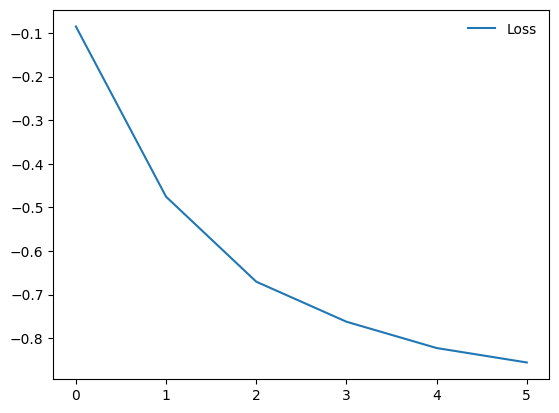

In [ ]:
# plot epochs vs lost
plt.plot(loss_list, label='Loss')
#plt.plot(collapse_list, label='Collapse')
plt.legend(frameon=False)
plt.show()

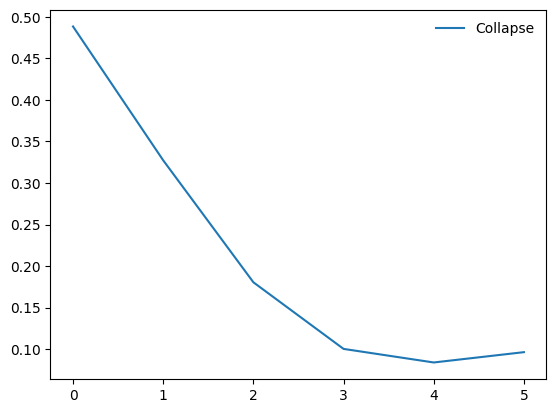

In [ ]:
# plot epochs vs lost
#plt.plot(loss_list, label='Loss')
plt.plot(collapse_list, label='Collapse')
plt.legend(frameon=False)
plt.show()

## Visualizing SDO tile clusters

In [ ]:
# Now that the model is trained, embed images into dataset
embeddings = []
filenames = []

# disable gradients for faster calculations
model.eval()
with torch.no_grad():
    # passes batches and filenames to model to find embeddings
    # embedding -> vectorize image, simpler representation of image
    for i, (x, _, fnames) in enumerate(dataloader_test):
        # move the images to the gpu
        x = x.to(device)
        # embed the images with the pre-trained backbone
        y = model.backbone(x).flatten(start_dim=1)
        # store the embeddings and filenames in lists
        embeddings.append(y)
        filenames = filenames + list(fnames)

# concatenate the embeddings and convert to numpy
embeddings = torch.cat(embeddings, dim=0)
embeddings = embeddings.cpu().numpy()

In [ ]:
# transform embeddings to 2D using UMAP (dimension reduction algorithm)

# for the scatter plot we want to transform the images to a two-dimensional
# vector space using a random Gaussian projection
projection = random_projection.GaussianRandomProjection(n_components=2)
embeddings_2d = projection.fit_transform(embeddings)

# normalize the embeddings to fit in the [0, 1] square
M = np.max(embeddings_2d, axis=0)
m = np.min(embeddings_2d, axis=0)
embeddings_2d = (embeddings_2d - m) / (M - m)

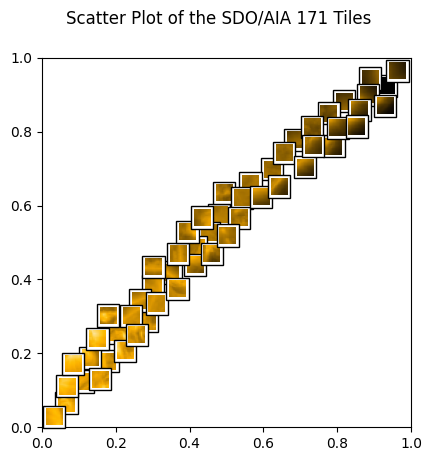

In [ ]:
# display a scatter plot of the dataset
# clustering similar images together

def get_scatter_plot_with_thumbnails():
    """Creates a scatter plot with image overlays."""
    # initialize empty figure and add subplot
    fig = plt.figure()
    fig.suptitle("Scatter Plot of the SDO/AIA 171 Tiles")
    ax = fig.add_subplot(1, 1, 1)
    # shuffle images and find out which images to show
    shown_images_idx = []
    shown_images = np.array([[1.0, 1.0]])
    iterator = [i for i in range(embeddings_2d.shape[0])]
    np.random.shuffle(iterator)
    for i in iterator:
        # only show image if it is sufficiently far away from the others
        dist = np.sum((embeddings_2d[i] - shown_images) ** 2, 1)
        if np.min(dist) < 2e-3:
            continue
        shown_images = np.r_[shown_images, [embeddings_2d[i]]]
        shown_images_idx.append(i)

    # plot image overlays
    for idx in shown_images_idx:
        thumbnail_size = int(rcp["figure.figsize"][0] * 2.0)
        path = os.path.join(path_to_data, filenames[idx])
        img = Image.open(path)
        img = functional.resize(img, thumbnail_size)
        img = np.array(img)
        img_box = osb.AnnotationBbox(
            osb.OffsetImage(img, cmap=plt.cm.gray_r),
            embeddings_2d[idx],
            pad=0.2,
        )
        ax.add_artist(img_box)

    # set aspect ratio
    ratio = 1.0 / ax.get_data_ratio()
    ax.set_aspect(ratio, adjustable="box")


# get a scatter plot with thumbnail overlays
get_scatter_plot_with_thumbnails()

# Nearest neighbour search

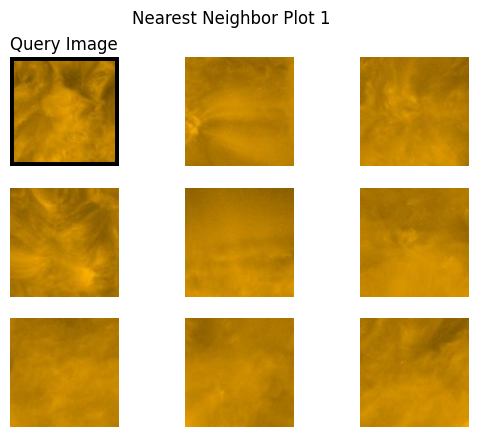

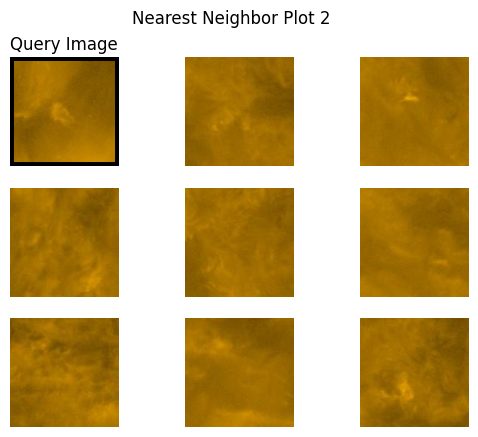

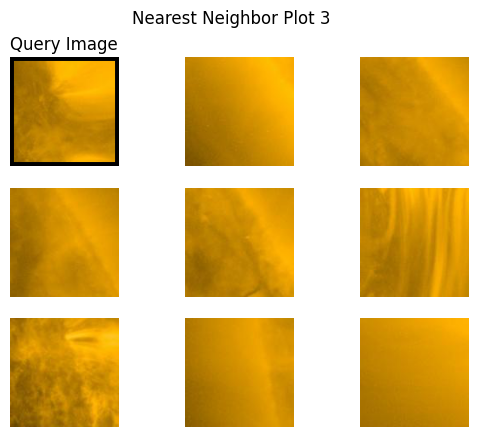

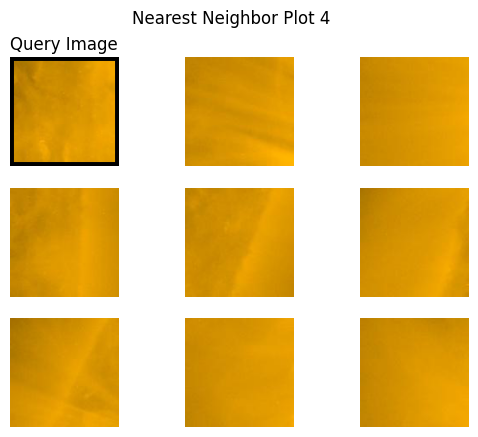

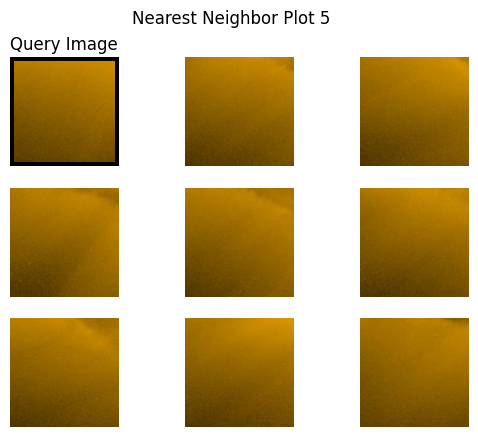

In [ ]:
# takes the 8 closest images to each example image and plot them together

example_images = [filenames[10**n] for n in range(5)]

def get_image_as_np_array(filename: str):
    """Loads the image with filename and returns it as a numpy array."""
    img = Image.open(filename)
    return np.asarray(img)


def get_image_as_np_array_with_frame(filename: str, w: int = 5):
    """Returns an image as a numpy array with a black frame of width w."""
    img = get_image_as_np_array(filename)
    ny, nx, _ = img.shape
    # create an empty image with padding for the frame
    framed_img = np.zeros((w + ny + w, w + nx + w, 3))
    framed_img = framed_img.astype(np.uint8)
    # put the original image in the middle of the new one
    framed_img[w:-w, w:-w] = img
    return framed_img


def plot_nearest_neighbors_3x3(example_image: str, i: int):
    """Plots the example image and its eight nearest neighbors."""
    n_subplots = 9
    # initialize empty figure
    fig = plt.figure()
    fig.suptitle(f"Nearest Neighbor Plot {i + 1}")
    #
    example_idx = filenames.index(example_image)
    # get distances to the cluster center
    distances = embeddings - embeddings[example_idx]
    distances = np.power(distances, 2).sum(-1).squeeze()
    # sort indices by distance to the center
    nearest_neighbors = np.argsort(distances)[:n_subplots]
    # show images
    for plot_offset, plot_idx in enumerate(nearest_neighbors):
        ax = fig.add_subplot(3, 3, plot_offset + 1)
        # get the corresponding filename
        fname = os.path.join(path_to_data, filenames[plot_idx])
        if plot_offset == 0:
            ax.set_title(f"Query Image")
            plt.imshow(get_image_as_np_array_with_frame(fname))
        else:
            plt.imshow(get_image_as_np_array(fname))
        # let's disable the axis
        plt.axis("off")


# show example images for each cluster
for i, example_image in enumerate(example_images):
    plot_nearest_neighbors_3x3(example_image, i)